In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
from IPython.display import SVG



## Project Settings

Specified here are the paths for the data and the features to run over in the list of best features.
Each entry in the list is a list containing one single string of the features to try, comma seperated. In this way it is easy to write a script to 
add entries to try very easily. 

In [2]:

##### set parameters
path_train_data = 'train.csv'
path_test_data = 'test.csv'
path_all_data = 'Dataset Correlated Removed.csv'

# set features here

best_features = [
     ['nof_acetyl, nof_COOH, nof_NH2, nof_SH, nof_negCharge, nof_HBA, molLogP'],
     ['nof_COOH, negCharge/Volume, posCharge/Volume, nof_posCharge, nof_HBA, nof_Chirals, molLogS'],
     ['nof_COOH, nof_SO3H, nof_PO4, nof_HBA, nof_Chirals, PSA/Area, molLogP'],
     ['nof_COOH, negCharge/Volume, nof_negCharge, nof_HBD, PSA/Area, molArea, molLogP'],
     ['nof_COOH, nof_PO4, negCharge/Volume, C_R1, nof_negCharge, nof_Chirals, molLogP'],
     ['negCharge/Volume, nof_negCharge, nof_posCharge, nof_Chirals, PSA/Area, molArea, molLogP'],
     ['nof_COOH, posCharge/Volume, a_heavy, nof_negCharge, PSA/Area, molArea, molLogP'],
     ['nof_SO3H, negCharge/Volume, a_heavy, nof_negCharge, nof_Rings, nof_HBA, nof_Chirals'],
     ['nof_COOH, nof_SO3H, posCharge/Volume, nof_negCharge, nof_HBA, molArea, molLogP'],
     ['nof_COOH, nof_SH, nof_SO3H, nof_PO4, a_heavy, nof_HBA, molArea'],
     ['nof_COOH, nof_SO3H, nof_PO4, a_heavy, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, nof_SH, nof_SO3H, nof_PO4, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, nof_NH2, nof_PO4, negCharge/Volume, posCharge/Volume, nof_HBA, PSA/Area'],
     ['nof_COOH, nof_SH, a_heavy, nof_negCharge, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, nof_SH, nof_negCharge, nof_HBD, nof_HBA, molArea, molLogP'],
     ['nof_COOH, nof_SH, nof_SO3H, posCharge/Volume, a_heavy, nof_HBA, molArea'],
     ['nof_COOH, nof_SH, nof_SO3H, posCharge/Volume, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, nof_SH, nof_PO4, nof_negCharge, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, a_heavy, nof_negCharge, nof_HBD, nof_HBA, nof_Chirals, molArea'],
     ['nof_COOH, nof_SH, nof_SO3H, nof_negCharge, nof_HBA, molArea, molLogP'],
     ['nof_COOH, nof_PO4, posCharge/Volume, a_heavy, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, nof_SH, nof_SO3H, nof_negCharge, nof_Rings, nof_HBA, molArea'],
     ['nof_SO3H, a_heavy, nof_negCharge, nof_Rings, nof_HBA, nof_Chirals, molArea'],
     ['nof_COOH, nof_SO3H, nof_PO4, nof_HBD, nof_HBA, nof_Chirals, molLogP'],
     ['nof_COOH, nof_SO3H, nof_PO4, nof_negCharge, nof_HBA, molArea, molLogP'],
     ['nof_SH, nof_PO4, posCharge/Volume, nof_negCharge, nof_Rings, nof_HBA, molArea'],
     ['nof_COOH, posCharge/Volume, nof_negCharge, nof_Rings, nof_HBA, molArea, molLogP'],
     ['nof_COOH, nof_PO4, posCharge/Volume, nof_HBD, nof_HBA, nof_Chirals, molLogP'],
     ['nof_COOH, nof_SH, C_sp3, a_heavy, nof_negCharge, nof_posCharge, molLogP'],
     ['nof_COOH, nof_SH, nof_SO3H, C_sp3, a_heavy, nof_negCharge, nof_Chirals'],
     ['nof_SO3H, nof_PO4, C_sp3, a_heavy, nof_negCharge, nof_Chirals, molLogP'],
     ['nof_SH, nof_SO3H, C_sp3, a_heavy, nof_negCharge, nof_posCharge, nof_Chirals'],
     ['nof_acetyl, nof_SH, nof_SO3H, C_sp3, a_heavy, nof_negCharge, nof_Chirals'],
     ['nof_COOH, nof_NH2, nof_PO4, C_sp3, a_heavy, nof_negCharge, nof_Chirals'],
     ['nof_COOH, nof_SO3H, C_sp3, a_heavy, nof_negCharge, nof_posCharge, nof_Chirals'],
     ['nof_acetyl, nof_RotB, negCharge/Volume, C_R1, nof_HBA, nof_Chirals, molLogP']

]

best_features = [list(map(str.strip, x[0].split(','))) for x in best_features]

k = len(best_features)


## Load Dataset

This code loads dataset into the variables below and converts the labels to categorical 0, 1 pairs.

In [3]:
# load dataset
all_data = pd.DataFrame(pd.read_csv(path_all_data))
all_labels = all_data['SLC'].astype('category').cat.codes
# drop labels
all_data.drop('SLC', axis=1, inplace=True)

train_data = pd.DataFrame(pd.read_csv(path_train_data))
train_labels = train_data['SLC'].astype('category').cat.codes
# drop labels

train_data.drop('SLC', axis=1, inplace=True)

test_data = pd.DataFrame(pd.read_csv(path_test_data))
test_labels = test_data['SLC'].astype('category').cat.codes
# drop labels
test_data.drop('SLC', axis=1, inplace=True)


## AUC and Classification Accuracy - Decision Tree

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [12]:
# visualize decision tree for input features
''' HYPERPARAMS FOR DECISION TREE
 
 These parameters implement a rudimentary pruning algorithm, would ideally like to use AB pruning'''
enable_pruning = True
# maximum depth of dtree
max_depth = 5
# how many samples your need atleast, at a LEAF node
min_samples = 3

d_trees = []


# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
dt_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        dtree = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
        dtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])        
        pred = dtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    dt_cas.append(np.mean(aucs))
    

# find AUC 
dt_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
    clf.fit(subset_train_data, train_labels)
    d_trees.append(clf)
    
    # make its predictions on test data
    pred = d_trees[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    dt_aucs.append(auc)
    
print('Decision Tree Results:')
print('\t    \tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(dt_aucs, dt_cas)):
    print('\t%3d' % i,'%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))


    

Decision Tree Results:
	    	AUC	Acc	Features
	  0 0.923	0.679	nof_acetyl, nof_COOH, nof_NH2, nof_SH, nof_negCharge, nof_HBA, molLogP
	  1 0.885	0.646	nof_COOH, negCharge/Volume, posCharge/Volume, nof_posCharge, nof_HBA, nof_Chirals, molLogS
	  2 0.885	0.621	nof_COOH, nof_SO3H, nof_PO4, nof_HBA, nof_Chirals, PSA/Area, molLogP
	  3 0.769	0.550	nof_COOH, negCharge/Volume, nof_negCharge, nof_HBD, PSA/Area, molArea, molLogP
	  4 0.808	0.542	nof_COOH, nof_PO4, negCharge/Volume, C_R1, nof_negCharge, nof_Chirals, molLogP
	  5 0.885	0.650	negCharge/Volume, nof_negCharge, nof_posCharge, nof_Chirals, PSA/Area, molArea, molLogP
	  6 0.885	0.779	nof_COOH, posCharge/Volume, a_heavy, nof_negCharge, PSA/Area, molArea, molLogP
	  7 0.692	0.725	nof_SO3H, negCharge/Volume, a_heavy, nof_negCharge, nof_Rings, nof_HBA, nof_Chirals
	  8 0.731	0.725	nof_COOH, nof_SO3H, posCharge/Volume, nof_negCharge, nof_HBA, molArea, molLogP
	  9 0.731	0.762	nof_COOH, nof_SH, nof_SO3H, nof_PO4, a_heavy, nof_HBA, molArea
	 

## AUC and Classification Accuracy - Random Forest Walk

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [11]:
# visualize random forest features
rfws = []

# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
rfw_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        rfwtree = RandomForestClassifier(n_estimators=100)
        rfwtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])
        pred = rfwtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    rfw_cas.append(np.mean(aucs))
    

# find AUC 
rfw_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(subset_train_data, train_labels)
    rfws.append(clf)
    
    # make its predictions on test data
    pred = rfws[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    rfw_aucs.append(auc)

print('Random Forest Results:')
print('\t    \tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(rfw_aucs, rfw_cas)):
    print('\t%3d' % i,'%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))


Random Forest Results:
	    	AUC	Acc	Features
	  0 0.962	0.692	nof_acetyl, nof_COOH, nof_NH2, nof_SH, nof_negCharge, nof_HBA, molLogP
	  1 1.000	0.704	nof_COOH, negCharge/Volume, posCharge/Volume, nof_posCharge, nof_HBA, nof_Chirals, molLogS
	  2 0.923	0.708	nof_COOH, nof_SO3H, nof_PO4, nof_HBA, nof_Chirals, PSA/Area, molLogP
	  3 0.923	0.750	nof_COOH, negCharge/Volume, nof_negCharge, nof_HBD, PSA/Area, molArea, molLogP
	  4 1.000	0.679	nof_COOH, nof_PO4, negCharge/Volume, C_R1, nof_negCharge, nof_Chirals, molLogP
	  5 0.923	0.713	negCharge/Volume, nof_negCharge, nof_posCharge, nof_Chirals, PSA/Area, molArea, molLogP
	  6 0.923	0.783	nof_COOH, posCharge/Volume, a_heavy, nof_negCharge, PSA/Area, molArea, molLogP
	  7 0.885	0.808	nof_SO3H, negCharge/Volume, a_heavy, nof_negCharge, nof_Rings, nof_HBA, nof_Chirals
	  8 0.962	0.812	nof_COOH, nof_SO3H, posCharge/Volume, nof_negCharge, nof_HBA, molArea, molLogP
	  9 1.000	0.779	nof_COOH, nof_SH, nof_SO3H, nof_PO4, a_heavy, nof_HBA, molArea
	 

## Visualizing individual decision trees

The tree in variable `dtree` is visualized by the cell below. We can see how it is pruned, the splitting rule, etc.

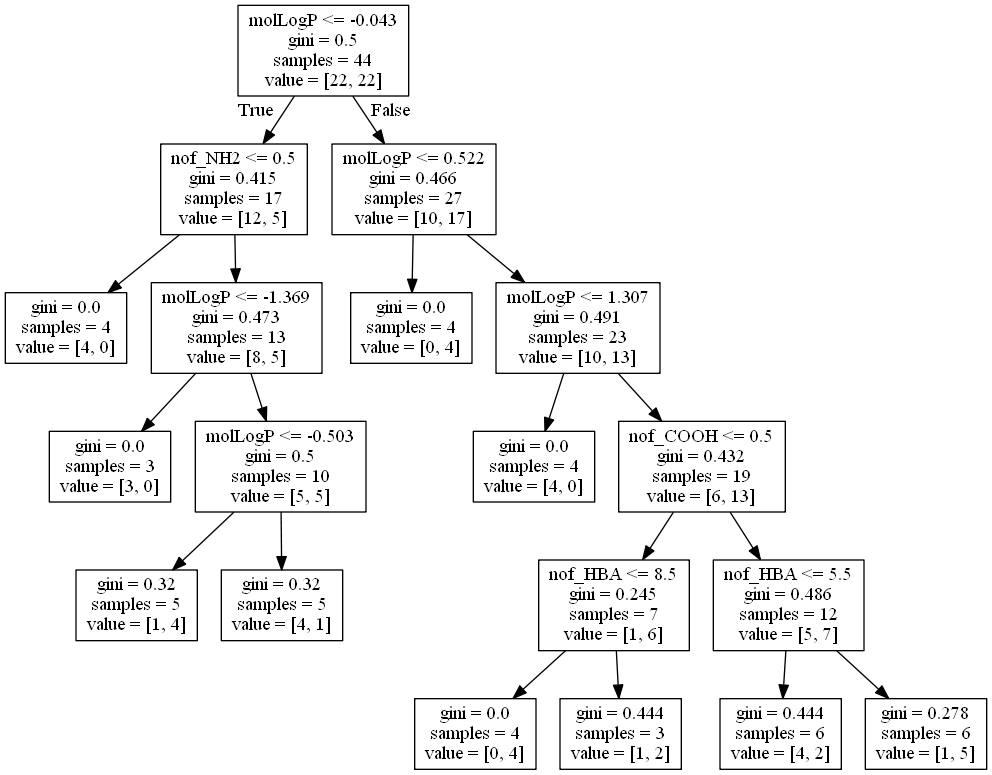

In [6]:
i = 0

dtree = d_trees[0]
graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
SVG(graph.pipe(format='svg'))            
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
graph.format = 'png'
graph.render('dtree_render',view=True)
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)
Image(png_bytes)

## Feature importance

The feature importances are compared below for decision trees and random forests.
Reported below is code to visualize all decision trees. This requires the graphviz package and has some bugs, which will be reported. This code visualizes all decision trees and finds the feature importances for all of them.

In [7]:
i = 0
# visualization
for dtree in d_trees:
    if i < k:
        print('Feature importances for tree and forest (resp.) %s/%s:' % (i + 1, k))
        for e in zip(dtree.feature_importances_, rfws[i].feature_importances_, best_features[i]):
            print('\t%6f\t%6f\t%s' % e)
        
        try:
            graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            SVG(graph.pipe(format='svg'))            
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            graph.format = 'png'
            graph.render('dtree_render',view=True)
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            png_bytes = graph.pipe(format='png')
            with open('dtree_pipe.png','wb') as f:
                f.write(png_bytes)
            Image(png_bytes)
        except:
            print('Something went wrong with rendering graph')
    else:
        print('Warning, code may be buggy')
    i += 1

Feature importances for tree and forest (resp.) 1/36:
	0.000000	0.039016	nof_acetyl
	0.050475	0.106833	nof_COOH
	0.068907	0.069666	nof_NH2
	0.000000	0.000000	nof_SH
	0.000000	0.065802	nof_negCharge
	0.143220	0.310096	nof_HBA
	0.737398	0.408588	molLogP
Feature importances for tree and forest (resp.) 2/36:
	0.000000	0.065363	nof_COOH
	0.172741	0.191135	negCharge/Volume
	0.349206	0.108574	posCharge/Volume
	0.000000	0.014509	nof_posCharge
	0.108844	0.188340	nof_HBA
	0.061395	0.095858	nof_Chirals
	0.307814	0.336222	molLogS
Something went wrong with rendering graph
Feature importances for tree and forest (resp.) 3/36:
	0.104403	0.090849	nof_COOH
	0.000000	0.000000	nof_SO3H
	0.000000	0.000000	nof_PO4
	0.232053	0.195616	nof_HBA
	0.157738	0.135110	nof_Chirals
	0.355125	0.270505	PSA/Area
	0.150681	0.307920	molLogP
Feature importances for tree and forest (resp.) 4/36:
	0.000000	0.043671	nof_COOH
	0.085084	0.120840	negCharge/Volume
	0.000000	0.029884	nof_negCharge
	0.000000	0.083281	nof_HBD
	0.087

Feature importances for tree and forest (resp.) 33/36:
	0.000000	0.057453	nof_acetyl
	0.000000	0.000000	nof_SH
	0.000000	0.000000	nof_SO3H
	0.167509	0.278169	C_sp3
	0.727402	0.472170	a_heavy
	0.082965	0.075628	nof_negCharge
	0.022124	0.116580	nof_Chirals
Feature importances for tree and forest (resp.) 34/36:
	0.000000	0.059180	nof_COOH
	0.022124	0.055901	nof_NH2
	0.000000	0.000000	nof_PO4
	0.167509	0.292032	C_sp3
	0.727402	0.423335	a_heavy
	0.082965	0.067204	nof_negCharge
	0.000000	0.102347	nof_Chirals
Feature importances for tree and forest (resp.) 35/36:
	0.000000	0.057030	nof_COOH
	0.000000	0.000000	nof_SO3H
	0.239173	0.337649	C_sp3
	0.675986	0.396902	a_heavy
	0.084842	0.072124	nof_negCharge
	0.000000	0.028048	nof_posCharge
	0.000000	0.108246	nof_Chirals
Feature importances for tree and forest (resp.) 36/36:
	0.000000	0.018018	nof_acetyl
	0.240486	0.242373	nof_RotB
	0.301395	0.171696	negCharge/Volume
	0.000000	0.104158	C_R1
	0.172009	0.143177	nof_HBA
	0.000000	0.077356	nof_Chirals
	